In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import umap.umap_ as umap
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import save_npz, csr_matrix

## Custom functions
from load_data import load_data
from preprocess import preprocess
from glove_embedder import GloveEmbedder

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobleooskar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobleooskar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacobleooskar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02CILab/Project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load Data

In [2]:
train_path_neg = "../twitter-datasets/train_neg.txt"
train_path_pos = "../twitter-datasets/train_pos.txt"
test_path = "../twitter-datasets/test_data.txt"

In [3]:
X_train, y_train, X_val, y_val, X_test = load_data(train_path_neg, train_path_pos, test_path, val_split=0.9 ,frac=0.2)

# Preprocess Data

In [4]:
X_train_tokens, X_val_tokens, X_test_tokens = preprocess(X_train, X_val, X_test)

Avg. Tweet Length (before preprocessing):  15.738694444444445
Avg. Tweet Length (after preprocessing):  7.601277777777778


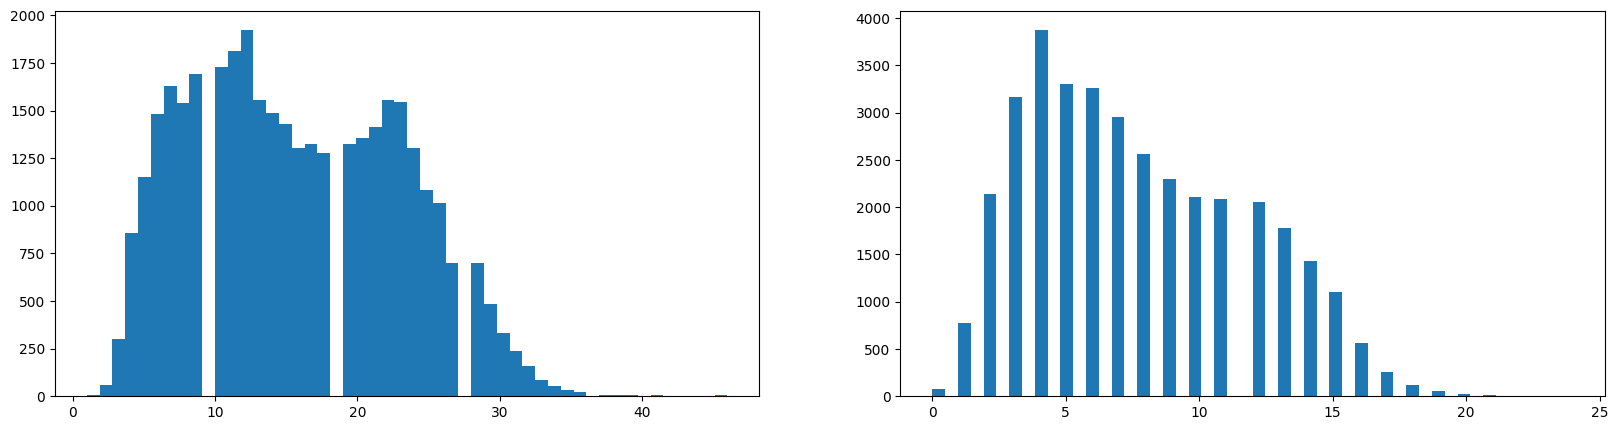

In [5]:
# plot histogram of most common tokens next to each other
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
tokenize = lambda x: x.split()
vals = [len(tokenize(tweet)) for tweet in X_train]
plt.hist(vals, bins=50)
print("Avg. Tweet Length (before preprocessing): ", np.mean(vals))

plt.subplot(1, 2, 2)
vals = [len(tweet) for tweet in X_train_tokens]
plt.hist(vals, bins=50)
print("Avg. Tweet Length (after preprocessing): ", np.mean(vals))

plt.show()

Total number of unique tokens (before preprocessing):  39826
Total number of  tokens (before preprocessing):  269472
Total number of unique tokens (after preprocessing):  26684
Total number of  tokens (after preprocessing):  70230


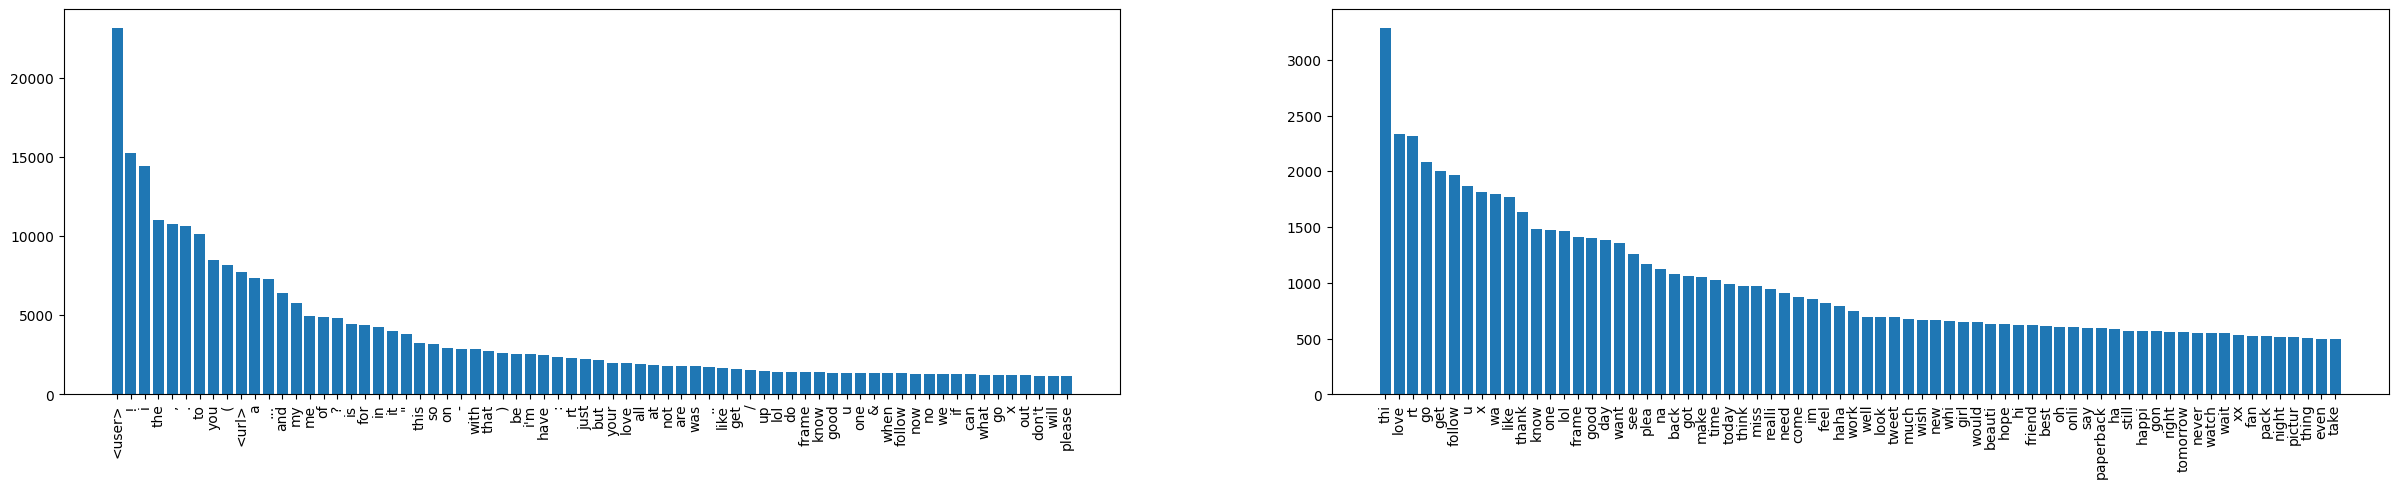

In [6]:
# plot most common tokens 
n = 70
plt.figure(figsize=(30, 5))

plt.subplot(1, 2, 1)
vals = [tokenize(tweet) for tweet in X_train]
c = Counter(itertools.chain(*vals))
plt.xticks(rotation=90) 
plt.bar([x[0] for x in c.most_common(n)], [x[1] for x in c.most_common(n)])
print("Total number of unique tokens (before preprocessing): ", len(c))
print("Total number of  tokens (before preprocessing): ", sum([x[1] for x in c.most_common(n)]))

plt.subplot(1, 2, 2)
c = Counter(itertools.chain(*X_train_tokens))
plt.xticks(rotation=90) 
plt.bar([x[0] for x in c.most_common(n)], [x[1] for x in c.most_common(n)])
vals = [len(tweet) for tweet in X_train_tokens]
print("Total number of unique tokens (after preprocessing): ", len(c))
print("Total number of  tokens (after preprocessing): ", sum([x[1] for x in c.most_common(n)]))

plt.show()

In [7]:
X_train_ = [' '.join(tokens) for tokens in X_train_tokens]
X_val_ = [' '.join(tokens) for tokens in X_val_tokens]
X_test_ = [' '.join(tokens) for tokens in X_test_tokens]

In [8]:
c_vec = CountVectorizer()
t_vec = TfidfVectorizer()
g_vec = GloveEmbedder();

X_train_c_vec = c_vec.fit_transform(X_train_)
X_train_t_vec = t_vec.fit_transform(X_train_)
X_train_g_vec = g_vec.transform(X_train_)

X_val_c_vec = c_vec.transform(X_val_)
X_val_t_vec = t_vec.transform(X_val_)
X_val_g_vec = g_vec.transform(X_val_)

X_test_c_vec = c_vec.transform(X_test_)
X_test_t_vec = t_vec.transform(X_test_)
X_test_g_vec = g_vec.transform(X_test_)

[===========---------------------------------------] 22.4% 23.4/104.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.3% 99.8/104.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
umap_1 = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, metric='euclidean', unique=True)
X_train_c_umap = umap_1.fit_transform(X_train_c_vec)
umap_2 = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, metric='euclidean', unique=True)
X_train_t_umap = umap_2.fit_transform(X_train_t_vec)
umap_3 = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, metric='euclidean', unique=True)
X_train_g_umap = umap_3.fit_transform(X_train_g_vec)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


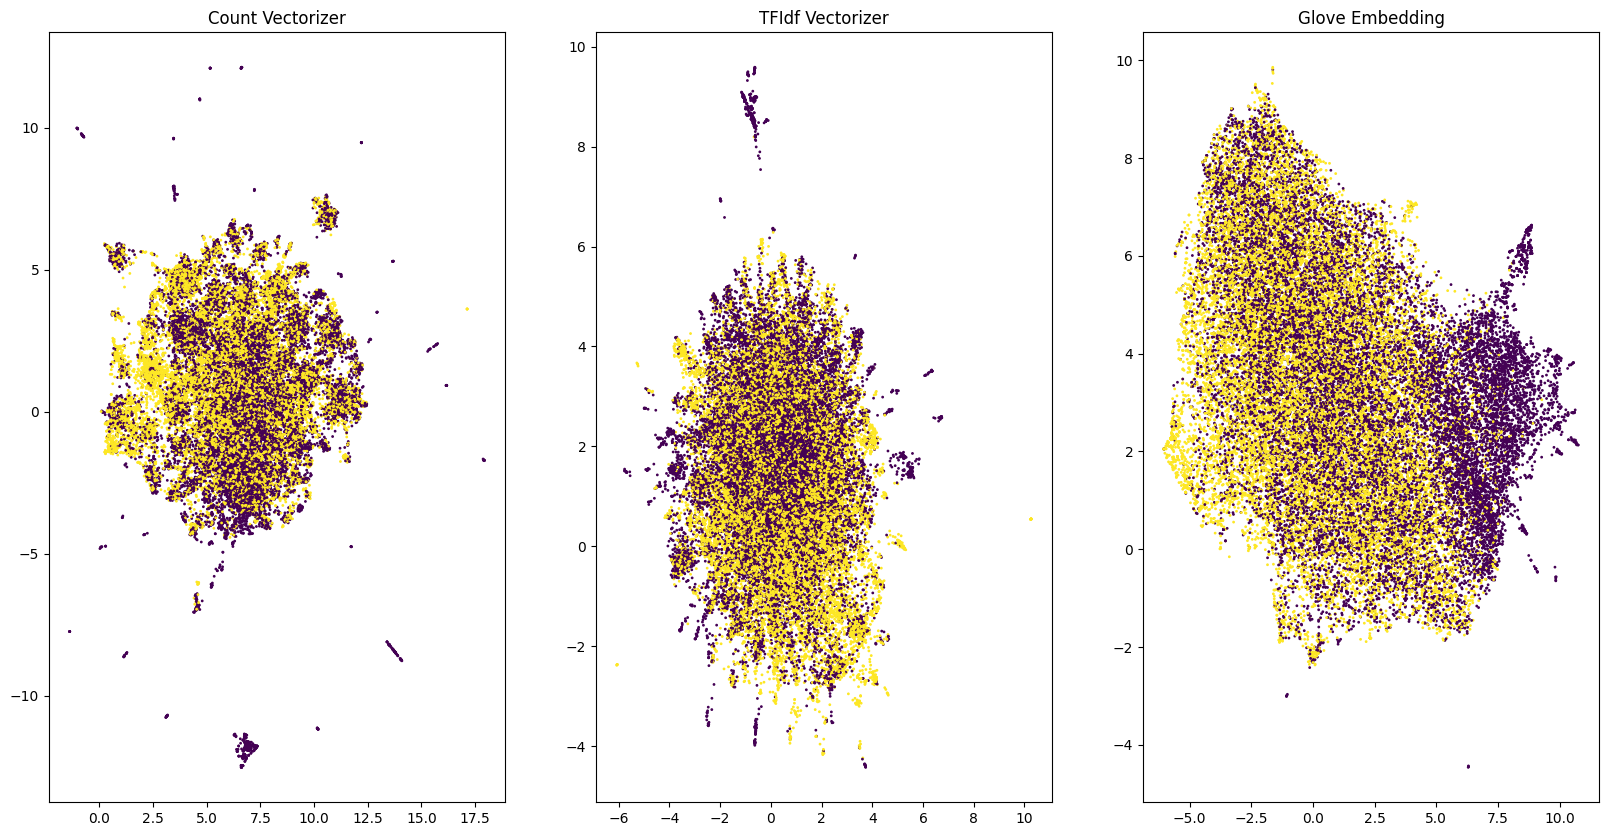

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.scatter(X_train_c_umap[:, 0], X_train_c_umap[:, 1], c=y_train, cmap='viridis', s=1)
plt.title("Count Vectorizer")

plt.subplot(1, 3, 2)
plt.scatter(X_train_t_umap[:, 0], X_train_t_umap[:, 1], c=y_train, cmap='viridis', s=1)
plt.title("TFIdf Vectorizer")

plt.subplot(1, 3, 3)
plt.scatter(X_train_g_umap[:, 0], X_train_g_umap[:, 1], c=y_train, cmap='viridis', s=1)
plt.title("Glove Embedding")

plt.show()

# Baseline Models

## Logistic Regression

In [11]:
lr_c = LogisticRegression(max_iter=10000);
lr_t = LogisticRegression(max_iter=10000);
lr_g = LogisticRegression(max_iter=10000);

lr_c.fit(X_train_c_vec, y_train)
lr_t.fit(X_train_t_vec, y_train)
lr_g.fit(X_train_g_vec, y_train)

LogisticRegression(max_iter=10000)

In [12]:
y_pred_c = lr_c.predict(X_val_c_vec)
y_pred_t = lr_t.predict(X_val_t_vec)
y_pred_g = lr_g.predict(X_val_g_vec)

print("Count Vectorizer: ", accuracy_score(y_val, y_pred_c))
print("TFIdf Vectorizer: ", accuracy_score(y_val, y_pred_t))
print("Glove Embedding: ", accuracy_score(y_val, y_pred_g))

Count Vectorizer:  0.759
TFIdf Vectorizer:  0.76075
Glove Embedding:  0.6615


## Stochastic Gradient Descent

In [13]:
sgdc_c = SGDClassifier()
sgdc_t = SGDClassifier()
sgdc_g = SGDClassifier()

sgdc_c.fit(X_train_c_vec, y_train)
sgdc_t.fit(X_train_t_vec, y_train)
sgdc_g.fit(X_train_g_vec, y_train)

SGDClassifier()

In [14]:
y_pred_c = sgdc_c.predict(X_val_c_vec)
y_pred_t = sgdc_t.predict(X_val_t_vec)
y_pred_g = sgdc_g.predict(X_val_g_vec)

print("Count Vectorizer: ", accuracy_score(y_val, y_pred_c))
print("TFIdf Vectorizer: ", accuracy_score(y_val, y_pred_t))
print("Glove Embedding: ", accuracy_score(y_val, y_pred_g))

Count Vectorizer:  0.75525
TFIdf Vectorizer:  0.7625
Glove Embedding:  0.65825


## Random Forest

In [15]:
rfc_c = RandomForestClassifier()
rfc_t = RandomForestClassifier()
rfc_g = RandomForestClassifier()

rfc_c.fit(X_train_c_vec, y_train)
rfc_t.fit(X_train_t_vec, y_train)
rfc_g.fit(X_train_g_vec, y_train)

RandomForestClassifier()

In [16]:
y_pred_c = rfc_c.predict(X_val_c_vec)
y_pred_t = rfc_t.predict(X_val_t_vec)
y_pred_g = rfc_g.predict(X_val_g_vec)

print("Count Vectorizer: ", accuracy_score(y_val, y_pred_c))
print("TFIdf Vectorizer: ", accuracy_score(y_val, y_pred_t))
print("Glove Embedding: ", accuracy_score(y_val, y_pred_g))

Count Vectorizer:  0.7545
TFIdf Vectorizer:  0.7595
Glove Embedding:  0.698


# Old

In [7]:
save_path = "../preprocessed_data/"
save_npz(save_path + 'X_train_c_vec', X_train_c_vec)
save_npz(save_path + 'X_train_t_vec', X_train_t_vec)
save_npz(save_path + 'X_val_c_vec', X_val_c_vec)
save_npz(save_path + 'X_test_c_vec', X_test_c_vec)
save_npz(save_path + 'X_val_t_vec', X_val_t_vec)
save_npz(save_path + 'X_test_t_vec', X_test_t_vec)
np.savez(save_path + "y_train", data=y_train.values)
np.savez(save_path + "y_val", data=y_val.values)

FileNotFoundError: [Errno 2] No such file or directory: '../preprocessed_data/X_train_c_vec.npz'